The naming of variables, columns etc. is according to the in the paper.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import itertools

import dataset
from rff import RFF
from backtest import Backtest

from joblib import Parallel, delayed

In [20]:
COLUMNS = dataset.COLUMNS
nber = dataset.load_nber()
data, returns = dataset.load_data()

# Standarize data

> We volatility standardize returns and predictors using backward-looking standard deviations that preserve the out-of-sample nature of our forecasts. 

> Returns are standardized by their trailing 12-month return standard deviation (to capture their comparatively fastmoving conditional volatility), while predictors are standardized using an expanding window historical standard deviation (given the much higher persistence of most predictors). 

> We require 36 months of data to ensure that we have enough stability in our initial predictor standardization, so the final sample that we bring to our analysis begins in 1930. We perform this standardization to align the empirical analysis with our homoskedastic theoretical setting, **but our results are insensitive to this step (none of our findings are sensitive to variations in how standardizations are implemented)**

I did try a few different normalizations and the end results seems to be nearly the same.

In [3]:
for col in COLUMNS:
    data[col] = (data[col] - data[col].expanding(36).mean())/data[col].expanding(36).std()
# Standarize return by the std of the last 12 values
returns_std = returns.rolling(12).std().shift()
returns = returns / returns_std

data = data[36:]
returns = returns[36:]

# Simulation

### Parameters

In [4]:
T = 12
gammas = [0.25, 0.5, 1, 2, 4]
z_values = list(np.logspace(-3, 6, 10))
iterations = list(np.arange(1, 201))

# I will be plotting c in a log-scale.
C_values = (
    list(np.logspace(-1, 0, 25, base=10)) +
    list(np.logspace(0, 1, 25, base=10)) +
    list(np.logspace(1, 2, 25, base=10)) +
    list(np.logspace(2, 3, 25, base=10))
)
P_values = [c*T for c in C_values]
# RFF does always create 2 features (sin & cos) => P is a multiple of 2.
# Get a unique list of multiple of 2s
P_values = list({2*round(P/2) for P in P_values})
P_values.sort()

### Backtest

In [11]:
# 1885min, 12 virtual cores
if "metrics.parquet"  in os.listdir("data"):
    metrics = pd.read_parquet(f"data/metrics.parquet")
else:
    # Parallelize via joblib.Parallel
    def simulation(data, returns, gamma, P, z, iteration):
        c = P/T
        rff_data = RFF(n=int(P/2), gamma=gamma).features(data, seed=iteration)
        # 1-step ahead prediction
        sim = Backtest(z=z, T=T).predict(X=rff_data, y=returns.shift(-1))
        performance = sim.performance()
        performance.update({"gamma": gamma, "P": P, "z": z, "c": c, "T": T, "iteration": iteration})
        return performance
    metrics = Parallel(n_jobs=-1)(delayed(simulation)(data, returns, gamma, P, z, iteration = seed) for gamma, P, z, seed in itertools.product(gammas, P_values, z_values, iterations))
    metrics = pd.DataFrame(metrics)
    metrics.to_parquet((f"data/metrics.parquet"))

metrics_mean = metrics.groupby(["gamma", "P", "z", "c", "T"]).mean().reset_index().drop("iteration", axis=1)
metrics_mean["log10(z)"] = np.log10(metrics_mean["z"])

### Baseline
Do the same 1-step ahead prediction with the standard dataset without added complexity.

In [6]:
baseline = []
for z in z_values:
    backtest = Backtest(z=z, T=T).predict(X=data[COLUMNS], y=returns.shift(-1))
    performance = backtest.performance()
    performance.update({"z": z})
    baseline.append(performance)
baseline = pd.DataFrame(baseline)
baseline

,beta_norm_mean,Market Sharpe Ratio,Expected Return,Volatility,R2,SR,IR,Alpha,Precision,Recall,Accuracy,z
0,8.325565,0.523715,-1.811731,11.211249,-4.146149,-0.161599,-0.216080,-2.018771e-01,0.614094,0.563945,0.530220,0.001
1,3.154551,0.523715,-0.404175,6.041112,-1.544987,-0.066904,-0.121859,-6.134675e-02,0.598765,0.597843,0.522894,0.010
2,1.059622,0.523715,0.358667,3.978746,-0.554554,0.090146,0.018443,6.115125e-03,0.615385,0.653313,0.551282,0.100
3,0.300594,0.523715,0.486357,2.381880,-0.142556,0.204191,0.086914,1.725160e-02,0.604250,0.701079,0.549451,1.000
4,0.075288,0.523715,0.264131,1.145966,-0.030430,0.230488,0.113001,1.079131e-02,0.614679,0.722650,0.565934,10.000
5,0.012751,0.523715,0.050221,0.270880,-0.018643,0.185399,0.120303,2.715631e-03,0.616385,0.730354,0.569597,100.000
6,0.001422,0.523715,0.005426,0.033065,-0.022218,0.164091,0.116642,3.214018e-04,0.617493,0.728814,0.570513,1000.000
7,0.000144,0.523715,0.000546,0.003388,-0.022808,0.161216,0.115971,3.273910e-05,0.617493,0.728814,0.570513,10000.000
8,0.000014,0.523715,0.000055,0.000340,-0.022870,0.160918,0.115900,3.280016e-06,0.617493,0.728814,0.570513,100000.000
9,0.000001,0.523715,0.000005,0.000034,-0.022877,0.160888,0.115892,3.280628e-07,0.617493,0.728814,0.570513,1000000.000


# Result

Note: **Footnote [25]**
> More specifically, the first column reports summary statistics for the market return with rolling 12-month volatility standardization. Thus, the buy-and-hold version of this asset is itself a basic timing strategy, where timing is inversely proportional to rolling volatility. We do this simply because the standardized market is the target in our forecasting analysis. Our results across the board are generally insensitive to, and our conclusions entirely unaffected by, whether we work with the raw or volatility standardized market return. As noted earlier, we prefer to use the volatility standardized market because it aligns more directly with our theoretical framework.

**Expected result:**

|    | High Complexity Machine |
|----|-------------------------|
|  z |                    1000 |
|  c |                    1000 |
| R2 |                      8% |
| SR | 0.46                    |
| IR | 0.31                    |

Page 48 reports R2 as "per month". The Sharpe Ratio value seems to be more fitting if you annualize the data.

The metrics are displayed blow. Compared to page 39:
- beta_norm_mean: fine
- Expected Return:fine
- Volatility: fine
- R2: **always below -10**
- Sharpe Ratio: fine
- Information Ratio: Instead of increasing from 0, it is hovering around 0-5%
- Alpha: It is decreasing instead of increasing and not starting at 0

The difference in Alpha and IR make me suspicious about my calculations. IR compares the timing strategy with the beta adjusted return and alpha is the intercept of the regression between the timing_strategy (forecast*returns) and returns.


# Plots
Here we create some plots for each metric. The left hand side is on a log-scale to better visualize the results for each `c in [0, 1000]` and the right hand side shows plots similar to the paper on a broken x-axis for `c in [0, 50] and c in [950, 1000]`.

Below are plots for specific metrics like Sharpe Ratio for a given range to better visualize the difference for each `log10(z)`. At the end we show plots for different `gamma` to check footnote [24]:
> We set γ = 2. Our results are generally insensitive to γ, as discussed in the robustness section below.

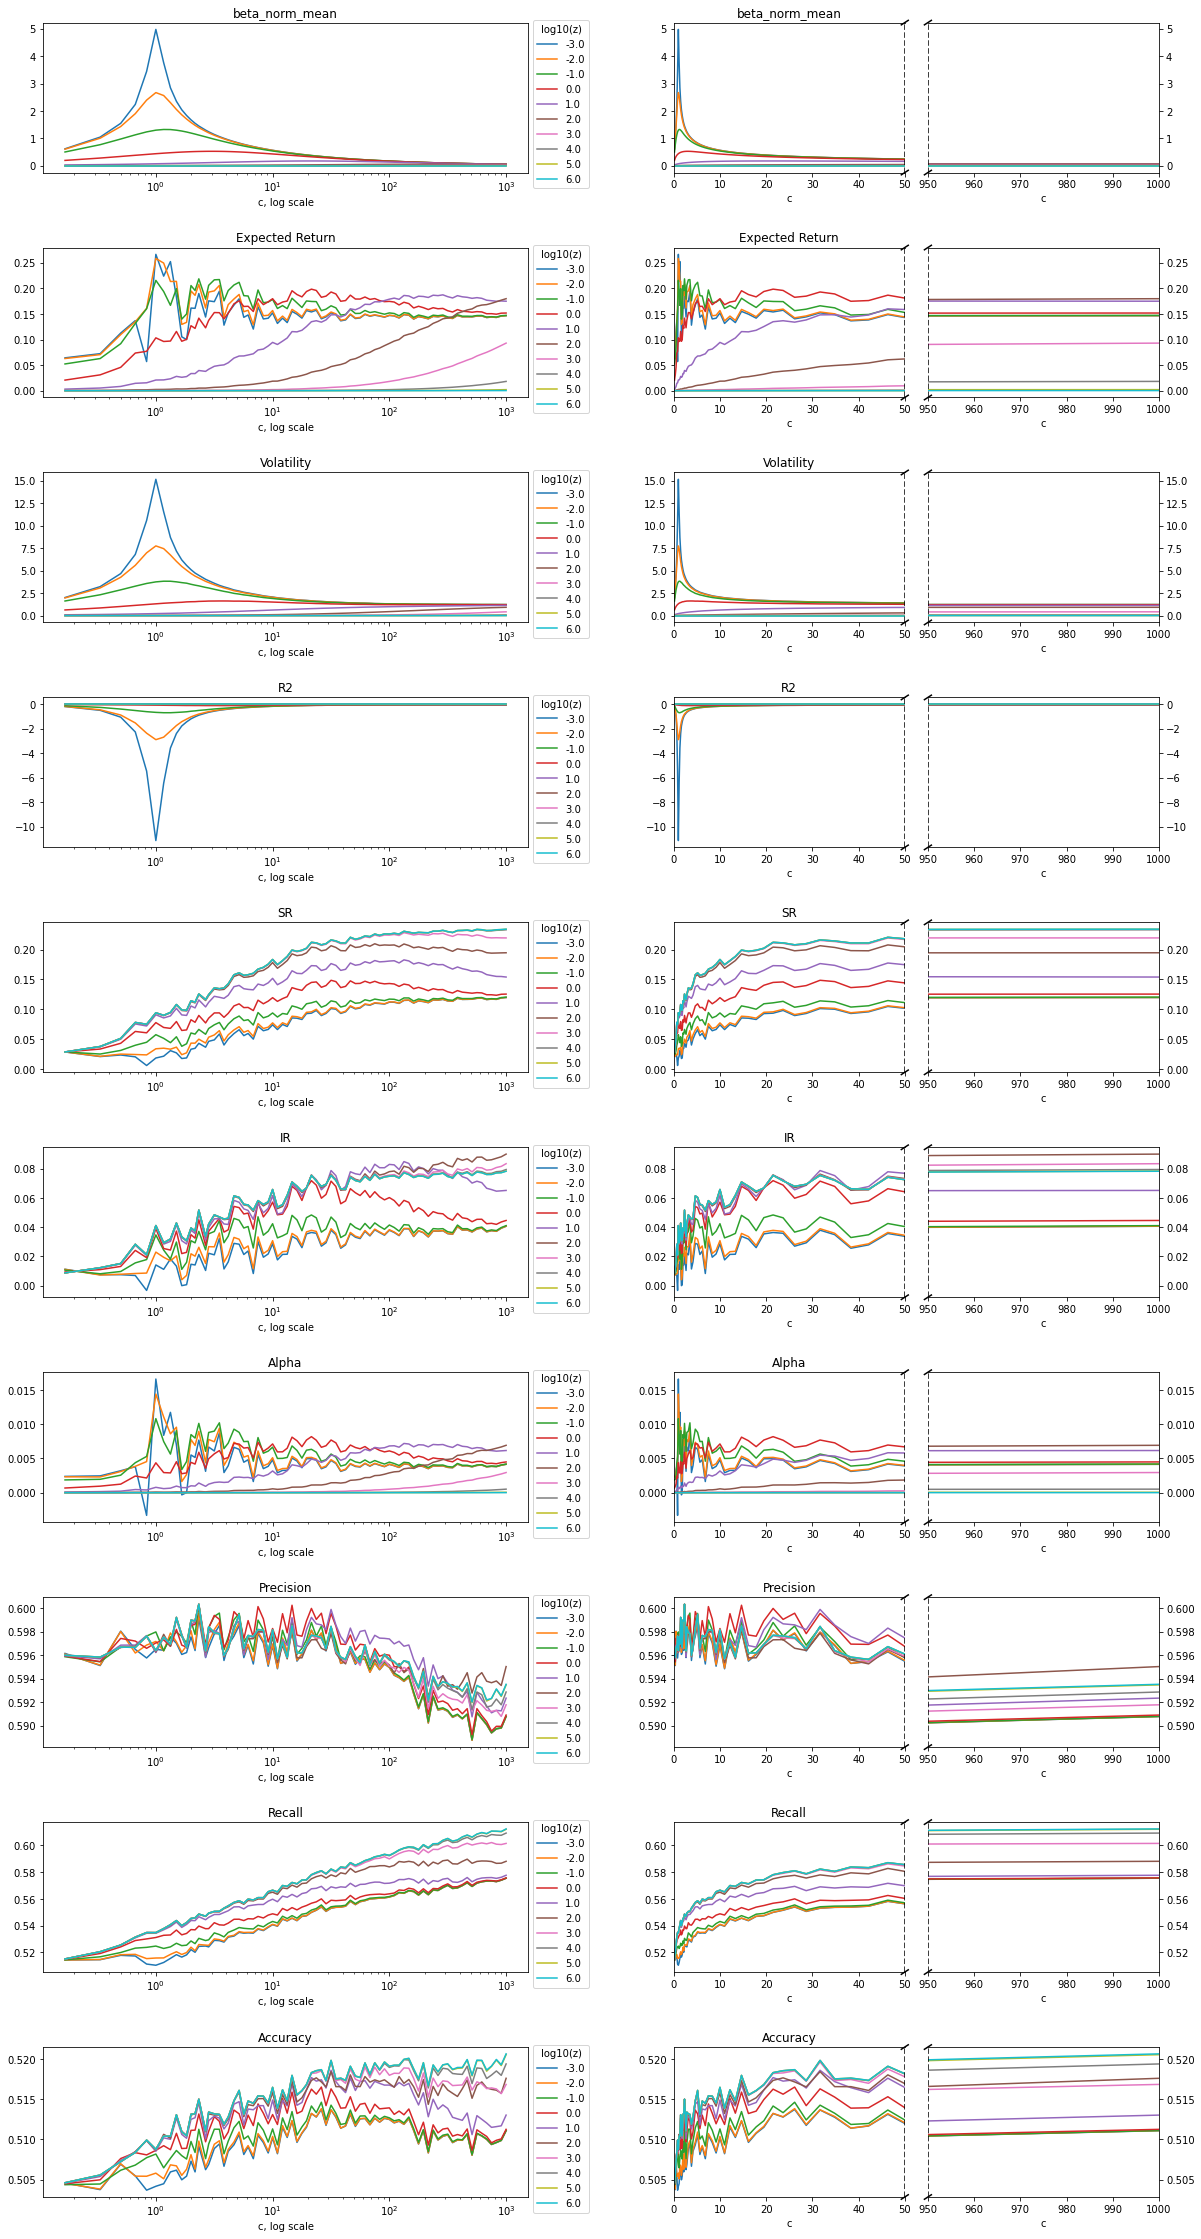

In [13]:
# https://stackoverflow.com/a/34934631/3002299

result = metrics_mean[metrics_mean["gamma"]==2]

fig = plt.figure(figsize=(20, 40))
outer = gridspec.GridSpec(1, 2, wspace=0.3, hspace=0.2)

plot_cols = ["beta_norm_mean", "Expected Return", "Volatility", "R2", "SR", "IR", "Alpha", "Precision", "Recall", "Accuracy"]
for i in range(2): # Outer
    inner = gridspec.GridSpecFromSubplotSpec(10, 1, subplot_spec=outer[i], wspace=0.5, hspace=0.5)
    if i == 0:
        for j in range(10): # Inner
            col = plot_cols[j]
            ax = plt.Subplot(fig, inner[j])
            result.set_index("c").groupby("log10(z)")[col].plot(ax=ax, title=col)
            ax.legend(loc="upper left", title="log10(z)", bbox_to_anchor=(1, 1.05))
            ax.set_xlabel("c, log scale")
            ax.set_xscale('log')
            fig.add_subplot(ax)
    else:  
        for j in range(10): # Inner
            col = plot_cols[j]

            double_inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=inner[j], wspace=0.1, hspace=0.1)
            
            ax1 = plt.Subplot(fig, double_inner[0])
            ax2 = plt.Subplot(fig, double_inner[1])
            result.set_index("c").groupby("log10(z)")[col].plot(ax=ax1, title=col)
            result.set_index("c").groupby("log10(z)")[col].plot(ax=ax2)
            ax1.set_xlim(0, 50)
            ax2.set_xlim(950, 1000)

            ax1.axvline(x=50, linestyle="--", c="black")
            ax2.axvline(x=950, linestyle="--", c="black")

            # hide the spines between ax and ax2
            ax1.spines['right'].set_visible(False)
            ax2.spines['left'].set_visible(False)
            #ax1.yaxis.tick_left()
            #ax1.tick_params(labelright='off')
            ax2.yaxis.tick_right()

            d = .015 # how big to make the diagonal lines in axes coordinates
            # arguments to pass plot, just so we don't keep repeating them
            kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
            ax1.plot((1-d,1+d), (-d,+d), **kwargs)
            ax1.plot((1-d,1+d),(1-d,1+d), **kwargs)

            kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
            ax2.plot((-d,+d), (1-d,1+d), **kwargs)
            ax2.plot((-d,+d), (-d,+d), **kwargs)

            fig.add_subplot(ax1)
            fig.add_subplot(ax2)
plt.show()

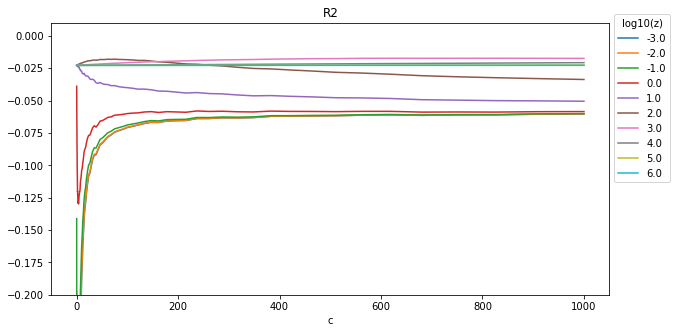

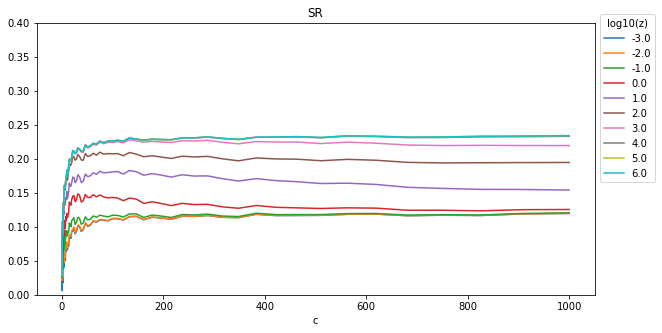

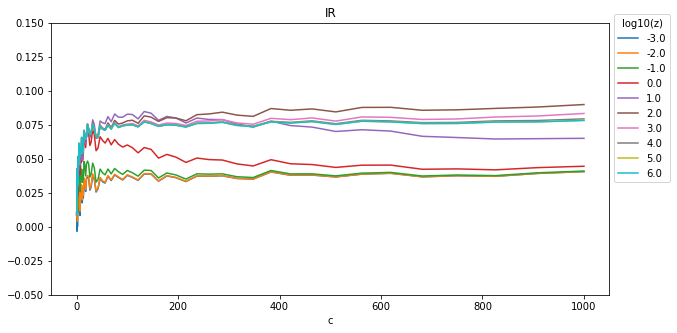

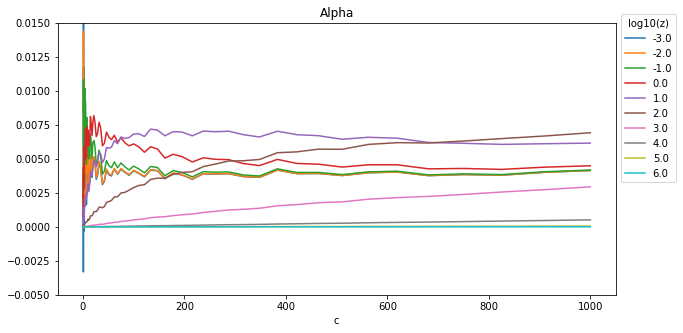

In [7]:
result.set_index("c").groupby("log10(z)")["R2"].plot(ylim=(-0.2,0.01), figsize=(10,5), title="R2")
plt.legend(loc="upper left", title="log10(z)", bbox_to_anchor=(1, 1.05))
plt.show()

result.set_index("c").groupby("log10(z)")["SR"].plot(ylim=(0.0, 0.4), figsize=(10,5), title="SR")
plt.legend(loc="upper left", title="log10(z)", bbox_to_anchor=(1, 1.05))
plt.show()

result.set_index("c").groupby("log10(z)")["IR"].plot(ylim=(-0.05,0.15), figsize=(10,5), title="IR")
plt.legend(loc="upper left", title="log10(z)", bbox_to_anchor=(1, 1.05))
plt.show()

result.set_index("c").groupby("log10(z)")["Alpha"].plot(ylim=(-0.005,0.015), figsize=(10,5), title="Alpha")
plt.legend(loc="upper left", title="log10(z)", bbox_to_anchor=(1, 1.05))
plt.show()

# Gamma

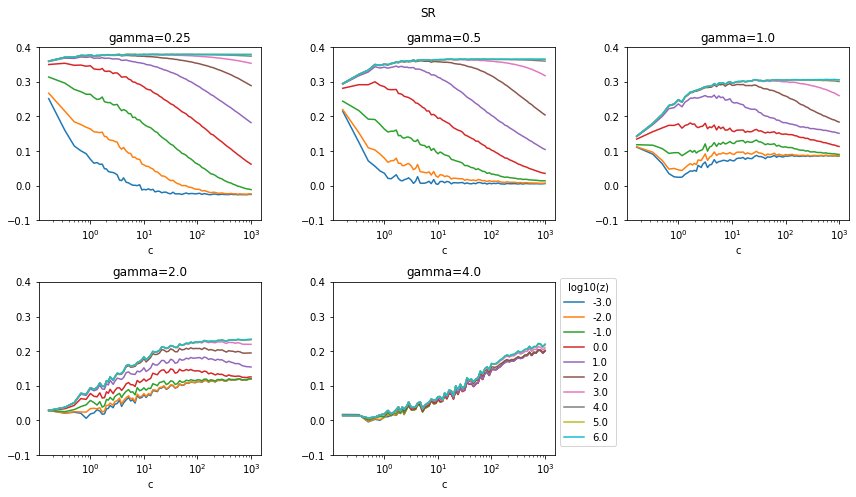

In [14]:
col = "SR"

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 7))
axs = axs.flatten()
for i, gamma in enumerate(metrics_mean["gamma"].unique()):
    metrics_mean[metrics_mean["gamma"]==gamma].set_index("c").groupby("log10(z)")[col].plot(ax=axs[i], title=f"gamma={gamma}")
    axs[i].set_xscale('log')
    axs[i].set_ylim(-0.1, 0.4)
axs[4].legend(loc="upper left", title="log10(z)", bbox_to_anchor=(1, 1.05))
fig.delaxes(axs[5])
fig.suptitle(col)
plt.tight_layout()
plt.show()